# Project 1 Submission
**Author: Badri Hiriyur** 

**Date: 12/17/2016**

All my project work is tracked on github. This project may be *git cloned* from git@github.com:bhiriyur/sdcnd.git

Below is the objective of this project.

### **Finding Lane Lines on the Road** 

In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---------------

### Helper functions (Unchanged)
Below are the basic helper functions provided to us. 

Also I have consolidated all the imports to the beginning of the file. The only additional module I import is 'time' to enable pausing while debugging.

In [2]:
# ImportsLines
import math
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import time
from moviepy.editor import VideoFileClip

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


### Drawing Lines
The function below has been modified significantly. The modifications (requested via an optional boolean input *consolidate*) include the following:
* Compute slopes and intersects of the lines
* Discard any flat lines (m close to 0)
* Separate left and right lanes (based on m being < or > 0)
* Average the slope (m) and intersect (b) for left and right lanes
* Extend the averaged lines between ymin = 0.6\*height and ymax = height

In [3]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3, consolidate=False):
    """
    Draws lines after consolidation (after averaging and extension) if requested.
    """
    # If requested, consolidate to two lines and extend    
    if consolidate:
        left, right = ([],[])
        for line in lines:
            for x1,y1,x2,y2 in line:            
                m = (y2-y1)/(x2-x1)
                b = (y1+y2-m*(x1+x2))/2
                # Skip flat lines
                if abs(m)<0.3: continue
                # Left vs. Right
                if m>0:
                    left.append([m,b])
                else:
                    right.append([m,b])

        # Average slope and intersect
        ml,bl = np.mean(left,axis=0)
        mr,br = np.mean(right,axis=0)

        # Limits
        height,width,depth = img.shape
        ymin = int(0.6*height)
        ymax = int(1.0*height)

        # Extend consolidated lines
        line = []
        xmin = int(min(width,max(0,(ymin-bl)/ml)))
        xmax = int(min(width,max(0,(ymax-bl)/ml)))
        line.append([xmin,ymin,xmax,ymax])

        xmin = int(min(width,max(0,(ymin-br)/mr)))
        xmax = int(min(width,max(0,(ymax-br)/mr)))
        line.append([xmin,ymin,xmax,ymax])

        lines= [line]

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    return


### Hough Lines and Weighted Averaging
The following functions are mostly unchanged from the form provided. The only minor change is the name of the Hough Lines function (added a P) indicating the OpenCV function being called. The reason I made this change is because I have another variant of this function that uses a Multiscale Hough Transform (using rho and theta output instead of [x1,y1,x2,y2] output). That variant did not work as well as this one so it is not being used. I will provide that variant at the end.

In [4]:
def hough_linesP(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns (x1,y1), (x2,y2) quadruplets
    """
    linesp = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                             minLineLength=min_line_len,
                             maxLineGap=max_line_gap)

    # Draw lines on image
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img,linesp,thickness=4,consolidate=True)

    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Image Processor 
The main image processing function that stacks the calls to various helper functions and returns the final processed output.

In [5]:
def process_image(img0, plot=False):
    ny, nx, nz = img0.shape

    # Step 1: Do Gaussian blur on grayscale
    kernel_size = 3
    img1 = gaussian_blur(grayscale(img0), kernel_size)

    # Step 2: Get Canny Transform
    low = 50
    high = 100
    img2 = canny(img1,low,high)

    # Step 3: Mask out peripheral content
    a = [0.49, 0.58, 0.05, 0.95]           # Factors [Htop, Vtop, HBottom, VBottom]
    vertices =[[[    a[0]*nx, a[1]*ny],    # Top left
                [    a[2]*nx, a[3]*ny],    # Bottom left
                [(1-a[2])*nx, a[3]*ny],    # Bottom right
                [(1-a[0])*nx, a[1]*ny]]]   # Top right
    img3 = region_of_interest(img2, np.array(vertices,dtype='int32'))

    # Step 4: Hough transform to detect lanes
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180   # angular resolution in radians of the Hough grid
    threshold = 10        # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10     # minimum number of pixels making up a line
    max_line_gap = 2      # maximum gap in pixels between connectable line segments
    img4 = hough_linesP(img3, rho, theta, threshold, min_line_len, max_line_gap)
    #img4 = hough_lines(img3, rho, theta, threshold)

    # Weighted average of original and lines
    img5 = weighted_img(img4, img0, α=0.8, β=5., λ=0.)

    # Draw on screen
    plt.ion()
    if plot:
        plt.imshow(img5)
        plt.draw()
        plt.pause(0.005)
        plt.show()

    return img5


# ** Image Results**

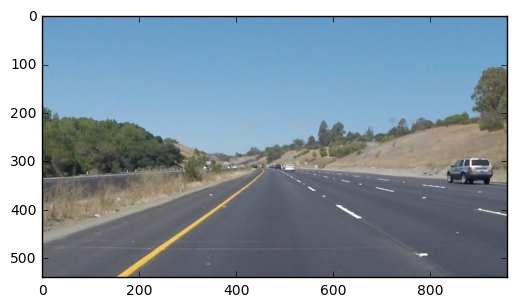

In [6]:
%matplotlib inline
## Input. Uncomment any line to verify

#image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(image)

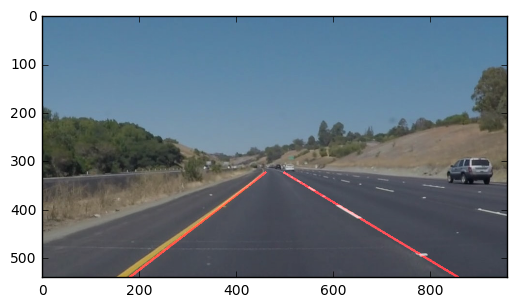

In [7]:
# Below is the output
plt.imshow(process_image(image))

# Video Processor
This helper function takes a video filename (foo.mp4) as input and writes the processed video output into input (foo_out.mp4).

In [8]:
def process_video(vidfile):
    white_output = vidfile.split('.')[0] + '_out.mp4'
    clip1 = VideoFileClip(vidfile)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)
    return white_output


## Video Results (SolidWhiteRight.mp4)

In [9]:
from IPython.display import HTML
out = process_video("solidWhiteRight.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("solidWhiteRight_out.mp4"))

[MoviePy] >>>> Building video solidWhiteRight_out.mp4
[MoviePy] Writing video solidWhiteRight_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 221/222 [00:11<00:00, 24.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidWhiteRight_out.mp4 

Wall time: 12.6 s


## Video Results (solidYellowLeft.mp4)

In [10]:
out = process_video("solidYellowLeft.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("solidYellowLeft_out.mp4"))

[MoviePy] >>>> Building video solidYellowLeft_out.mp4
[MoviePy] Writing video solidYellowLeft_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:29<00:00, 23.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: solidYellowLeft_out.mp4 

Wall time: 30.9 s


## Video Results (challenge.mp4)

In [11]:
out = process_video("challenge.mp4")
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("challenge_out.mp4"))

[MoviePy] >>>> Building video challenge_out.mp4
[MoviePy] Writing video challenge_out.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:21<00:00, 11.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_out.mp4 

Wall time: 24.2 s


# Reflections

Challenge.mp4 was *challenging* as the name indicated. Some of the features that caused issues were:

* A portion of the bonnet is visible in the bottom causing additional edges to appear (resolved by a combination of limiting the mask region above the bonnet edge and discarding 'flat' lines)
* Changes in the pavement surface
* Shadows in the mask region 
* Curvature of the road

Some of the flickers still remain and I plan to address them in a future submission time permitting. Here is one thought on how to go about it:

1. In the function draw_lines, the computed m and b values for both lane lines are stored as attributes of the function (persistent between function calls)
2. If the computed m and b values differ significantly from the stored m and b values (from previous frame), discard and use the stored values

# Additional Features
Here are a few additional features that I think may be useful for motion planning and other excercizes to come.

1. Auto-identifying lane type on both sides (solid or broken)
2. Auto-indentifying lane line color (yellow or white)
3. Identifying lane curvature to left or right

\#1 and \#2 seem to be fairly straightforward based on the output of Canny and HoughLines. \#3 also seems doable based on identifying the lane markings specifically near the middle of the image. However it seems that this may be an easy classification problem for a convolutional neural network to solve instead of manually hardcoding in the features.